In [63]:
import os 
import string
from glob import glob 
import pandas as pd
import numpy as np
import zipfile

import xvec

import xarray as xr
import geopandas as gpd
import rasterio
import rioxarray as rio
import shapely.geometry
from shapely.geometry import Point

import folium
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [64]:

# Path to data zip file
zip_path = "Data.zip"

# Folder to extract to
extract_to = "Data/"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


### Load LAI

In [6]:
lai_files = glob("./Data/lai_cropped/*.tif")

basename = []
for x in lai_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-19:-4])
    basename.append(name)


time = xr.Variable('time', basename)
lai_da = xr.concat([rio.open_rasterio(f) for f in lai_files], dim=time)
lai_da = lai_da.sortby("time")
lai_ds = lai_da.to_dataset(dim="band").rename_vars({1:"lai"})

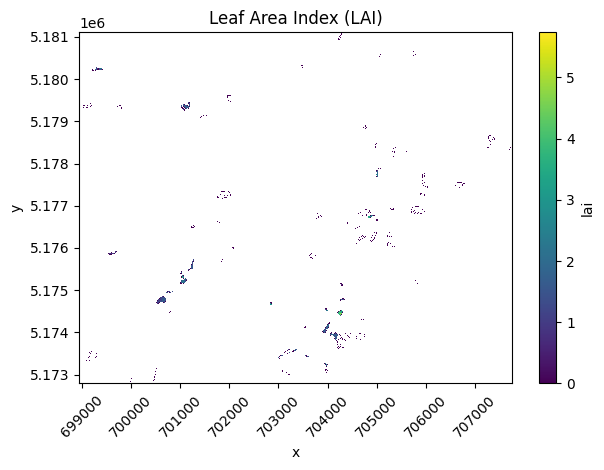

In [15]:
# Plot LAI
ax = lai_ds["lai"].isel(time=0).plot() 
ax = plt.gca()

ax.set_title("Leaf Area Index (LAI)")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

### Load Sentinel-1 RTC

In [14]:
rtc_asc_files = glob("./Data/RTC_asc_cropped/*.tif")
basename = []
for x in rtc_asc_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-12:-4])
    basename.append(name)


time = xr.Variable('time', basename)
rtc_asc = xr.concat([rio.open_rasterio(f) for f in rtc_asc_files], dim=time)
rtc_asc = rtc_asc.sortby("time")
rtc_asc = rtc_asc.to_dataset(dim="band").rename_vars({1:"asc_vv", 2:"asc_vh"})

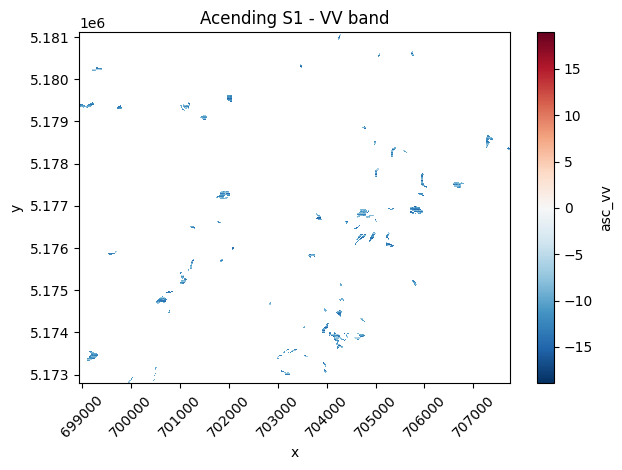

In [21]:
# Plot Acending S1 VV band
ax = rtc_asc["asc_vv"].isel(time=0).plot() 
ax = plt.gca()

ax.set_title("Acending S1 - VV band")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [17]:
rtc_dsc_files = glob("./Data/RTC_dsc_cropped/*.tif")
basename = []
for x in rtc_dsc_files:
    name = os.path.basename(x)
    name = pd.to_datetime(name[-12:-4])
    basename.append(name)


time = xr.Variable('time', basename)
rtc_dsc = xr.concat([rio.open_rasterio(f) for f in rtc_dsc_files], dim=time)
rtc_dsc = rtc_dsc.sortby("time")
rtc_dsc = rtc_dsc.to_dataset(dim="band").rename_vars({1:"dsc_vv", 2:"dsc_vh"})

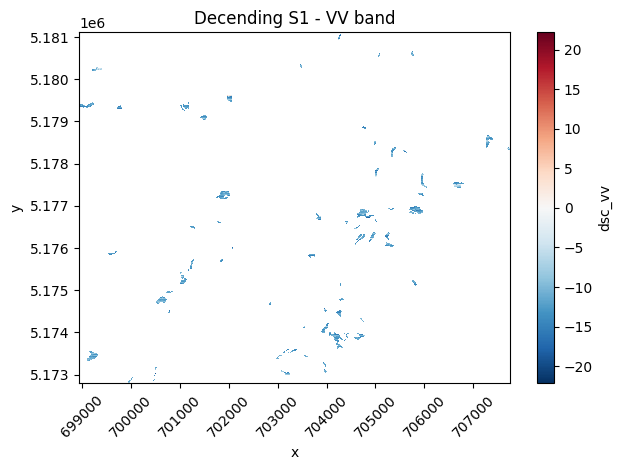

In [20]:
# Plot Dcending S1 VV band
ax = rtc_dsc["dsc_vv"].isel(time=0).plot() 
ax = plt.gca()

ax.set_title("Decending S1 - VV band")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

### Load the farms

In [22]:
from shapely.geometry import box
farms = gpd.read_file("./Data/shp/farms.shp")
farms = farms.to_crs(epsg=4326)

print("There are ", farms.shape[0], " farms")

There are  66  farms


In [24]:
farms.head(5)

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,Lon,Lat,geometry
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,11.609432,46.745927,"POLYGON ((11.60803 46.7457, 11.60802 46.74572,..."
1,2452708,AP2,Prato stabile,Wiese (Dauerwiese),610.494102,-0.466073,33.243051,1763.564030,S,S_coll,11.621647,46.681033,"MULTIPOLYGON (((11.62123 46.67986, 11.62125 46..."
2,2753189,AP2,Prato stabile,Wiese (Dauerwiese),605.398214,0.254297,9.608795,5781.321955,N,N_coll,11.664703,46.704917,"MULTIPOLYGON (((11.66388 46.70483, 11.66388 46..."
3,2286544,AP2,Prato stabile,Wiese (Dauerwiese),858.793483,-0.033078,15.239743,29644.776476,S,S_coll,11.679018,46.713566,"MULTIPOLYGON (((11.67739 46.71279, 11.67739 46..."
4,2881455,AP2,Prato stabile,Wiese (Dauerwiese),1059.817219,0.288833,9.422010,13395.827122,N,N_submont,11.685488,46.707456,"MULTIPOLYGON (((11.68467 46.70658, 11.68468 46..."


In [26]:
# Plot the farms over Sentinel-2 Data
farms['centroid'] = farms['geometry'].centroid
farms['Lon'] = farms['centroid'].x
farms['Lat'] = farms['centroid'].y

# Create a map and check the location of each cluster
center_lat, center_lon =  farms['Lat'].mean(), farms['Lon'].mean()


map_farms = leafmap.Map(location=[center_lat, center_lon], zoom_start=13)
map_farms.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")

style_function = lambda x: {'fillColor': '#3366cc', 'color': '#3366cc'}

folium.GeoJson(farms['geometry'], style_function=style_function).add_to(map_farms)
map_farms

### Feature Engineering for S1
This step focuses on feature engineering for Sentinel-1 (S1) data, highlighting key features such as the VV/VH ratio and the Radar Vegetation Index (RVI) to improve the model performance later.

In [27]:
# Feature engineering for descending sentinel-1 data
rtc_dsc['dsc_vv/vh'] = rtc_dsc['dsc_vv'] / rtc_dsc['dsc_vh']
rtc_dsc['dsc_rvi'] = (4*rtc_dsc['dsc_vv']) / (rtc_dsc['dsc_vv'] + rtc_dsc['dsc_vh'])

# Feature engineering for ascending sentinel-1 data
rtc_asc['asc_vv/vh'] = rtc_asc['asc_vv'] / rtc_asc['asc_vh']
rtc_asc['asc_rvi'] = (4*rtc_asc['asc_vv']) / (rtc_asc['asc_vv'] + rtc_asc['asc_vh'])

### Vector cubes Functions

In [28]:
# Get the same CRS for the farms and raster data cubes
farms = farms.to_crs(epsg=32632)
farms.drop(columns="centroid", inplace=True)

#### Extract points 
Extract values from the raster data cubes using farm centroids and randomly distributed points to create representative datasets for model training.

In [32]:
# Get the centroid of each farm
farms = gpd.GeoDataFrame(farms, geometry='geometry')
farms["x"] = farms.geometry.centroid.x
farms["y"] = farms.geometry.centroid.y

# Create list of shapely Points of the farms centroids 
points = [Point(xy) for xy in zip(farms['x'], farms['y'])]

In [33]:
# Extract LAI values 
extracted_lai = lai_ds.xvec.extract_points(points, x_coords="x", y_coords="y")

In [34]:
# Ectract RTC desending Sentinel-1
extracted_rtc_dsc = rtc_dsc.xvec.extract_points(points, x_coords="x", y_coords="y")

In [35]:
# Ectract RTC ascending Sentinel-1
extracted_rtc_asc = rtc_asc.xvec.extract_points(points, x_coords="x", y_coords="y")

In [36]:
### Extract random points 
# Get the bounding box of the farm GeoDataFrame
bbox = farms.total_bounds  # returns (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = bbox

# Sample N random points in the bounding box
def random_points_in_bbox(minx, miny, maxx, maxy, n):
    xs = np.random.uniform(minx, maxx, n)
    ys = np.random.uniform(miny, maxy, n)
    return [shapely.geometry.Point(x, y) for x, y in zip(xs, ys)]

# Generate the points
random_points = random_points_in_bbox(minx, miny, maxx, maxy, 500)
extracted_lai = lai_ds.xvec.extract_points(random_points, x_coords="x", y_coords="y")

#### Zonal statistcs 
Aggregate the values of raster data cubes for each farm, based on their geometries, to generate vector data cubes indexed by farm geometries instead of longitude and latitude.

In [39]:
# Zonal statistcs 
aggregated_lai_farms = lai_ds.xvec.zonal_stats(
    farms.geometry,
    x_coords="x",
    y_coords="y",
    stats="mean",
    name = "farm"
)

In [40]:
# Zonal statistcs 
aggregated_rtc_dsc_farms = rtc_dsc.xvec.zonal_stats(
    farms.geometry,
    stats=["mean", "sum"],
    x_coords="x",
    y_coords="y",
    name = "farm"
)

In [41]:
# Zonal statistcs 
aggregated_rtc_asc_farms = rtc_asc.xvec.zonal_stats(
    farms.geometry,
    stats=["mean", "sum"],
    x_coords="x",
    y_coords="y",
    name = "farm"
)
aggregated_rtc_asc_farms

<xarray.Dataset> Size: 138kB
Dimensions:           (zonal_statistics: 2, farm: 66, time: 65)
Coordinates:
    spatial_ref       int64 8B 0
  * time              (time) datetime64[ns] 520B 2023-03-05 ... 2023-11-26
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'sum'
  * farm              (farm) object 528B POLYGON ((699211.6412465982 5180209....
Data variables:
    asc_vv            (farm, zonal_statistics, time) float32 34kB -9.565 ... ...
    asc_vh            (farm, zonal_statistics, time) float32 34kB -16.51 ... ...
    asc_vv/vh         (farm, zonal_statistics, time) float32 34kB 0.5719 ... ...
    asc_rvi           (farm, zonal_statistics, time) float32 34kB 1.44 ... 13.99
Indexes:
    farm     GeometryIndex (crs=EPSG:32632)
Attributes:
    STATISTICS_MAXIMUM:  8.5030002593994
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  -18.784999847412
    STATISTICS_STDDEV:   -9999
    AREA_OR_POINT:       Area
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('RTC_VV', 'RTC_VH')

#### Indexing & Selecting Data

In [42]:
farms.head(3)

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,Lon,Lat,geometry,x,y
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,11.609432,46.745927,"POLYGON ((699211.641 5180209.026, 699210.869 5...",699317.948254,5.180237e+06
1,2452708,AP2,Prato stabile,Wiese (Dauerwiese),610.494102,-0.466073,33.243051,1763.564030,S,S_coll,11.621647,46.681033,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",700491.273765,5.173058e+06
2,2753189,AP2,Prato stabile,Wiese (Dauerwiese),605.398214,0.254297,9.608795,5781.321955,N,N_coll,11.664703,46.704917,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",703693.920050,5.175822e+06


In [43]:
# Select specific farm
farm_id = 1782222
selected_farm = farms[farms["ID"] ==  farm_id]
geom = selected_farm.geometry[0]
selected_farm

,ID,CODE,DESCR_IT,DESCR_DE,elev,northness,slope,area,face,class,Lon,Lat,geometry,x,y
0,1782222,AP2,Prato stabile,Wiese (Dauerwiese),1384.621242,-0.790552,18.553996,7238.380564,S,S_mont,11.609432,46.745927,"POLYGON ((699211.641 5180209.026, 699210.869 5...",699317.948254,5.180237e+06


In [44]:
# Select S1 ASC RTC data based on the geometry of the selected farm
selected_farm = aggregated_rtc_asc_farms.sel(farm=[geom])

In [45]:
# Select LAI data within 2.5 km around the geometry of the selected farm
selected_farms = aggregated_lai_farms.xvec.query("farm", [geom.buffer(2500)])

### Modeling
Build farm-level models using Random Forests by first applying zonal statistics (mean aggregation) to convert raster data cubes into vector form, followed by data cleaning, matching, validation, and inference.

In [47]:
# Generta the vector data cube to be used for modeing
aggregated_lai_farms = lai_ds.xvec.zonal_stats(
    farms.geometry,
    x_coords="x",
    y_coords="y",
    stats="mean",
    name = "farm"
)

aggregated_rtc_dsc_farms = rtc_dsc.xvec.zonal_stats(
    farms.geometry,
    stats="mean",
    x_coords="x",
    y_coords="y",
    name = "farm",
    all_touched=True
)

aggregated_rtc_asc_farms = rtc_asc.xvec.zonal_stats(
    farms.geometry,
    stats="mean",
    x_coords="x",
    y_coords="y",
    name = "farm",
    all_touched=True
)

#### Data cleaning, Matching with 3-day tolerance

In [48]:
# Initialize storage
matched_lai = []
matched_asc = []
matched_dsc = []
## to store the mathced times
matched_times_asc = [] 
matched_times_dsc = []
matched_times = []

# Tolerance in days
tolerance = 3



# iterate over the time coordinates of LAI dataset
for idx, t1 in enumerate(aggregated_lai_farms.time.values):
    # find the corresponding time coordinates in S1 RTC dataset within the tolerance

    # Match with S1 asc
    asc_time_diff = np.abs((aggregated_rtc_asc_farms.time.values - t1)) / np.timedelta64(1, 'D')
    dsc_time_diff = np.abs((aggregated_rtc_dsc_farms.time.values - t1)) / np.timedelta64(1, 'D') 

    asc_mask = asc_time_diff <= tolerance
    dsc_mask = dsc_time_diff <= tolerance

    
    if np.any(asc_mask) and np.any(dsc_mask):
        asc_time = aggregated_rtc_asc_farms.time.values[asc_mask][-1]
        dsc_time = aggregated_rtc_dsc_farms.time.values[dsc_mask][-1]
        
        if (asc_time not in matched_times_asc) and (dsc_time not in matched_times_dsc):  #(not np.isin(asc_time[-1], matched_times_asc)) and (not np.isin(dsc_time[-1], matched_times_dsc)):
            #print(t1)
            matched_lai.append(aggregated_lai_farms.sel(time=t1))
            matched_asc.append(aggregated_rtc_asc_farms.sel(time=asc_time))
            matched_dsc.append(aggregated_rtc_dsc_farms.sel(time=dsc_time))

            matched_times_asc.append(asc_time)
            matched_times_dsc.append(dsc_time)
            matched_times.append(t1)


In [49]:
# concatenate the matched data
if matched_lai:
    merged_lai = xr.concat(matched_lai, dim='concat_dim')
else:
    merged_lai = xr.Dataset()
    
if matched_asc:
    merged_asc = xr.concat(matched_asc, dim='concat_dim')
else:
    merged_asc = xr.Dataset()

if matched_dsc:
    merged_dsc = xr.concat(matched_dsc, dim='concat_dim')
else:
    merged_dsc = xr.Dataset()

In [50]:
# merge the concatenated data
if not merged_lai.equals(xr.Dataset()) and not merged_asc.equals(xr.Dataset()) and not merged_dsc.equals(xr.Dataset()):
    merged_ds = xr.merge([merged_lai, merged_asc, merged_dsc], compat='override')
else:
    merged_ds = xr.Dataset()

In [51]:
merged_ds = merged_ds.assign_coords(concat_dim=merged_ds.time.values)
merged_ds = merged_ds.drop_vars('time')
merged_ds = merged_ds.rename_dims({'concat_dim': 'time'})
merged_ds = merged_ds.rename_vars({'concat_dim': 'time'})

#### Reformate the data into data frame to be used for Random Forest 

In [526]:
variable_names = list(merged_ds.data_vars.keys())

In [54]:
df = merged_ds.xvec.to_geodataframe()
df = df.reset_index()
df['Day_of_Year'] = df['time'].dt.dayofyear
df_output = df
df_output.head(3)

,time,farm,lai,spatial_ref,asc_vv,asc_vh,asc_vv/vh,asc_rvi,dsc_vv,dsc_vh,dsc_vv/vh,dsc_rvi,Day_of_Year
0,2023-04-03 10:05:51,"POLYGON ((699211.641 5180209.026, 699210.869 5...",1.319309,0,-10.776989,-16.649954,0.643431,1.557189,-12.497297,-18.138912,0.690954,1.630548,93
1,2023-04-03 10:05:51,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",0.337563,0,-11.686157,-17.777981,0.659239,1.585341,-12.483173,-19.013706,0.656611,1.579153,93
2,2023-04-03 10:05:51,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",0.955983,0,-10.855891,-17.747578,0.609809,1.509823,-12.313130,-18.533188,0.662624,1.588195,93


In [55]:
df_farms = df_output.groupby(["farm","Day_of_Year"])

In [56]:
lai_df = df_output.dropna().reset_index(drop=True)
lai_df.head(3)

,time,farm,lai,spatial_ref,asc_vv,asc_vh,asc_vv/vh,asc_rvi,dsc_vv,dsc_vh,dsc_vv/vh,dsc_rvi,Day_of_Year
0,2023-04-03 10:05:51,"POLYGON ((699211.641 5180209.026, 699210.869 5...",1.319309,0,-10.776989,-16.649954,0.643431,1.557189,-12.497297,-18.138912,0.690954,1.630548,93
1,2023-04-03 10:05:51,"MULTIPOLYGON (((700463.641 5172926.726, 700464...",0.337563,0,-11.686157,-17.777981,0.659239,1.585341,-12.483173,-19.013706,0.656611,1.579153,93
2,2023-04-03 10:05:51,"MULTIPOLYGON (((703631.585 5175810.696, 703631...",0.955983,0,-10.855891,-17.747578,0.609809,1.509823,-12.313130,-18.533188,0.662624,1.588195,93


#### Training & Validation
Spatial cross-validation & Feature importance

In [57]:
# Spatial cross validation with RMSE & MAE metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score


lai_df = gpd.GeoDataFrame(lai_df, geometry='farm')
lai_df["x"] = lai_df.farm.centroid.x
lai_df["y"] = lai_df.farm.centroid.y
# Define block size in meters (5km blocks)
block_size = 5000
lai_df["block"] = (
    (lai_df["x"] // block_size).astype(str) + "_" +
    (lai_df["y"] // block_size).astype(str)
)

# Sample: lai_df["block"] contains strings like "123_456"
blocks = lai_df["block"].unique()
blocks.sort()  # optional: sort blocks consistently

# Generate letter labels: A, B, ..., Z, AA, AB, ...
def generate_labels(n):
    alphabet = list(string.ascii_uppercase)
    labels = []
    while len(labels) < n:
        for first in [""] + alphabet:
            for second in alphabet:
                labels.append(first + second)
                if len(labels) == n:
                    return labels

labels = generate_labels(len(blocks))

# Create mapping from old to new
block_map = dict(zip(blocks, labels))

# Apply it
lai_df["block"] = lai_df["block"].map(block_map)

['C' 'D' 'E' 'G' 'A' 'B' 'F' 'H']


<Axes: >

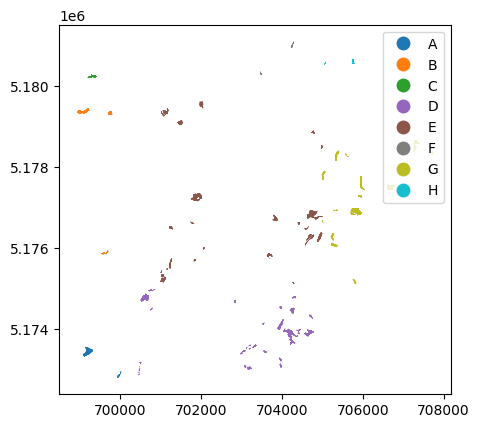

In [58]:
print(lai_df["block"].unique())
lai_df.plot(column="block", legend=True)

In [59]:
# Clean data
groups = lai_df["block"]

X = lai_df.drop(["x","y", "block", 'lai', 'lai', 'farm',"spatial_ref", "time"], axis=1) 
y = lai_df['lai']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Spatial cross validation
cv = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=cv, groups=groups, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print("Spatial CV RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())


mae_scores = cross_val_score(model, X, y, cv=cv, groups=groups, scoring="neg_mean_absolute_error")

print("Spatial CV MAE scores:", -mae_scores)

Spatial CV RMSE scores: [1.37818879 1.28772218 1.29998083 1.17707544 1.62936024]
Mean RMSE: 1.3544654961600853
Spatial CV MAE scores: [1.09455484 1.0549227  1.05714652 0.94044006 1.35777724]


#### Feature importance

In [60]:
# Clean data
groups = lai_df["block"]
X = lai_df.drop(["x","y", "block", 'lai', 'farm',"time", "Day_of_Year", "spatial_ref"], axis=1)
y = lai_df['lai']


# spatial CV
group_kfold = GroupKFold(n_splits=2)

for i, (tr_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
    # spliting the data
    X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # Fit THE model
    model = RandomForestRegressor(random_state=2025)
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_val)

    print("MSE:", mean_squared_error(y_val, y_pred))
    print("RMSE:", root_mean_squared_error(y_val, y_pred))
    break
    

MSE: 2.1935709179197302
RMSE: 1.4810708686351677


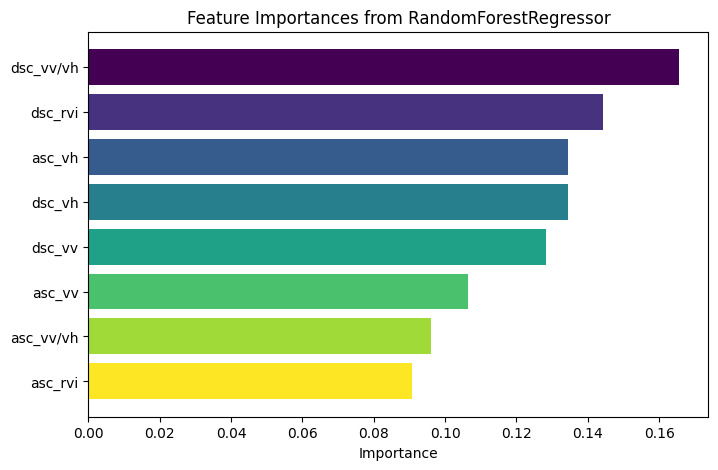

In [62]:
# Get feature importances
importances = model.feature_importances_
feature_names = model.feature_names_in_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
colors = cm.viridis(np.linspace(0, 1, len(importance_df)))
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances from RandomForestRegressor")
plt.show()